<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/6.%20Redes%20Recurrentes/Practica6.4.%20Procesamiento%20de%20secuencias%20con%20ConvNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 6.4. Procesamiento de secuencias con CNNs

In [1]:
from tensorflow import keras
keras.__version__

'2.4.0'

Vamos a comprobar como las redes convolucionales de una dimensión (1D) son también útiles para procesar secuencias. Si vemos una secuencia como un vector de una dimensión, una convolución aplicada sobre ese vector debería ser capaz de detectar patrones interesantes de forma similar a como lo haría una red recurrente. Veamos cómo funciona, y cuándo utilizarlo.

## 1. Implementando una convnet 1D

En Keras, usaríamos una convnet 1D a través de la capa `Conv1D`, que tiene una interfaz muy similar a `Conv2D`. Toma como entrada tensores 3D con forma `(samples, time, features)` y también devuelve tensores 3D de forma similar. La ventana de convolución es una ventana 1D en el eje temporal, eje 1 en el tensor de entrada.

Construyamos una convnet 1D de 2 capas y apliquémosla a la tarea de clasificación de sentimientos IMDB.

A modo de recordatorio, este es el código para obtener y preprocesar los datos:

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # número de palabras a considerar como características
max_len = 500  # cortar textos después de este número de palabras (entre las características máximas más comunes)

print('Cargando datos...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'secuencias de entrenamiento')
print(len(x_test), 'secuencias de test')

print('Pad sequences (samples x tiempo)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Cargando datos...
17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 secuencias de entrenamiento
25000 secuencias de test
Pad sequences (samples x tiempo)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


Las convnets 1D están estructuradas de la misma manera que sus versiones 2D que se ya hemos utilizado en módulo 5: consisten en una pila de capas `Conv1D` y `MaxPooling1D`, terminando eventualmente en una capa de pooling global o una capa `Flatten`, convirtiendo las salidas 3D en salidas 2D, permitiendo añadir una o más capas `Dense` al modelo, para clasificación o regresión.

Una diferencia, sin embargo, es el hecho de que podemos permitirnos el lujo de usar ventanas de convolución más grandes con convnets 1D. De hecho, con una capa de convolución 2D, una ventana de convolución 3x3 contiene `3*3 = 9` vectores de características, pero con una capa de convolución 1D, una ventana de convolución de tamaño 3 sólo contendría 3 vectores de características. De esta manera podemos permitirnos fácilmente ventanas de convolución 1D de tamaño 7 o 9.

Este es nuestro ejemplo de convneto 1D para el conjunto de datos IMDB:

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

Aquí están nuestros resultados con los conjuntos de entrenamiento y validación: la precisión de la validación es algo inferior a la del LSTM que utilizamos hace dos prácticas, pero el tiempo de ejecución es más rápido, tanto en la CPU como en la GPU (aunque la velocidad exacta variará mucho dependiendo de la configuración exacta). En este punto, podríamos volver a entrenar este modelo para el número correcto de épocas (8), y ejecutarlo con el conjunto de prueba. Esta es una demostración convincente de que una convnet 1D puede ofrecer una alternativa rápida y barata a una red recurrente en una tarea de clasificación de sentimientos a nivel de palabra.

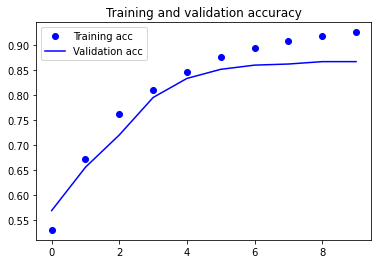

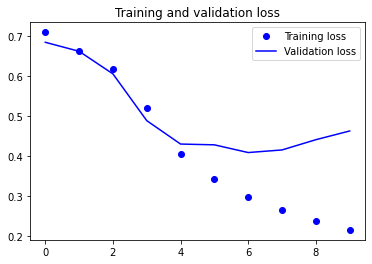

In [4]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2. Combinando CNNs y RNNs para procesar secuencias largas

Debido a que las convnets 1D procesan los parches de entrada de forma independiente, no son sensibles al orden de los pasos temporales (más allá de una escala local, el tamaño de las ventanas de convolución), a diferencia de las RNNs. Por supuesto, para poder reconocer patrones a más largo plazo, uno podría apilar muchas capas de convolución y acumular capas, resultando en capas superiores que "verían" pedazos largos de las entradas originales -- pero esa es todavía una manera bastante débil de inducir la sensibilidad al orden. Una forma de evidenciar esta debilidad es probar las convnets 1D sobre el problema del pronóstico de temperatura de la práctica anterior, donde la sensibilidad al orden fue clave para producir buenas predicciones. Veamos:

In [5]:
# Reutilizamos las siguientes variables definidas en la práctica anterior:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

# descarga los datos si no estaban
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# Esta es la cantidad de pasos que hay que seguir en `val_gen`
# para ver todo el conjunto de validación:
val_steps = (300000 - 200001 - lookback) // batch_size

# Esta es la cantidad de pasos a seguir en `test_gen`
# para ver todo el conjunto de pruebas:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

--2020-12-22 10:05:55--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.110.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.110.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  39.8MB/s    in 0.3s    

2020-12-22 10:05:56 (39.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [6]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 50s 99ms/step - loss: 0.4724 - val_loss: 0.4407
Epoch 2/20
500/500 [==============================] - 43s 86ms/step - loss: 0.3680 - val_loss: 0.4416
Epoch 3/20
500/500 [==============================] - 44s 88ms/step - loss: 0.3425 - val_loss: 0.4433
Epoch 4/20
500/500 [==============================] - 43s 86ms/step - loss: 0.3261 - val_loss: 0.4351
Epoch 5/20
500/500 [==============================] - 43s 85ms/step - loss: 0.3113 - val_loss: 0.4495
Epoch 6/20
500/500 [==============================] - 42s 85ms/step - loss: 0.3027 - val_loss: 0.4490
Epoch 7/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2955 - val_loss: 0.4514
Epoch 8/20
500/500 [==============================] - 43s 87ms/step - loss: 0.2896 - val_loss: 0.4414
Epoch 9/20
500/500 [==============================] - 44s 87ms/step - loss: 0.2809 - val_loss: 0.4431
Epoch 10/20
500/500 [==============================] - 45s 90ms/step - loss: 0.278

Aquí están nuestros errores absolutos medios sobre nuestro conjunto de entrenamiento y validación:

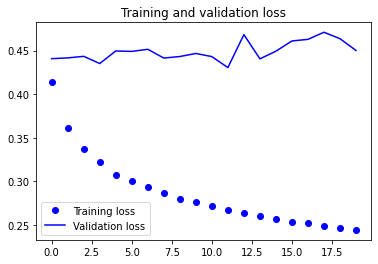

In [7]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

La validación MAE se mantiene en los 0,40: ni siquiera podemos superar nuestra base de sentido común utilizando una convnet pequeña. Una vez más, esto se debe a que nuestro convnet busca patrones en cualquier parte de las series de tiempo de entrada, y no tiene conocimiento de la posición temporal de un patrón que ve (por ejemplo, hacia el principio, hacia el final, etc.). En este caso específico, dado que los puntos de datos más recientes deben interpretarse de forma diferente a los más antiguos, la convnet no consigue producir resultados significativos. Esta limitación de las convnets no fue un problema en IMDB, porque los patrones de palabras clave que se asocian con un sentimiento positivo o negativo serán informativos independientemente de dónde se encuentren en las frases de entrada.

Una estrategia para combinar la velocidad y ligereza de las convnets con la sensibilidad al orden de los RNNs es utilizar una convnet 1D como paso de preprocesamiento antes de uan RNN. Esto es especialmente beneficioso cuando se trata de secuencias que son tan largas que no se pueden procesar de forma realista con RNNs, por ejemplo, secuencias con miles de pasos. La convnet convertirá la secuencia de entrada larga en secuencias mucho más cortas (de menor tamaño) de características de nivel superior. Esta secuencia de características extraídas se convierte en la entrada a la parte RNN de la red.

Esta técnica no se ve muy a menudo en trabajos de investigación y aplicaciones prácticas, posiblemente porque no es muy conocida. Es muy eficaz y debería ser más común. Probemos esto en el conjunto de datos de pronóstico de temperatura. Debido a que esta estrategia nos permite manipular secuencias mucho más largas, podríamos mirar los datos desde más atrás (aumentando el parámetro `lookback` del generador de datos), o mirar en series de tiempo de alta resolución (disminuyendo el parámetro `step` del generador). Aquí, elegiremos (de forma arbitraria) usar un `step` dos veces más pequeño, resultando en series de tiempo dos veces más largas, donde los datos climáticos están siendo muestreados a una tasa de un punto por 30 minutos.

In [8]:
# Esto estaba antes asignado a 6 (un punto por hora)
# Ahora 3 (un punto por 30 min).
step = 3
lookback = 720  # Igual
delay = 144 # Igual

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

Este es nuestro modelo, comenzando con dos capas `Conv1D` y seguidasa con una capa `GRU`:

In [9]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 94s 182ms/step - loss: 0.3685 - val_loss: 0.2888
Epoch 2/20
500/500 [==============================] - 89s 179ms/step - loss: 0.3033 - val_loss: 0.2783
Epoch 3/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2907 - val_loss: 0.2762
Epoch 4/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2784 - val_loss: 0.2798
Epoch 5/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2704 - val_loss: 0.2837
Epoch 6/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2630 - val_loss: 0.2795
Epoch 7/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2559 - val_loss: 0.2829
Epoch 8/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2510 - val_loss: 0.2842
Epoch 9/20
500/500 [==============================] - 90s 181ms/step - loss: 0.2427 - val_loss: 0.2956
Epoch 10/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2409

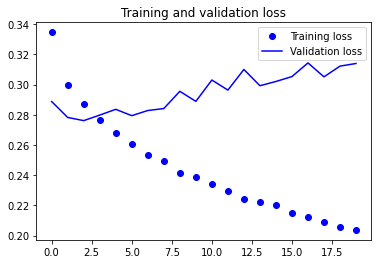

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

A juzgar por la validation loss, esta configuración no es tan buena como la del GRU regularizado por si solo, pero es significativamente más rápida. Trata de examinar dos veces más datos, lo que en este caso no parece ser de gran ayuda, pero puede ser importante para otros conjuntos de datos.

## 3. Concluyendo

Esto es lo que deberías haber aprendido en esta práctica:

* De la misma manera que las convnets 2D funcionan bien para procesar patrones visuales en espacio 2D, las convnets 1D funcionan bien para procesar patrones temporales. Ofrecen una alternativa más rápida a las RNN en algunos problemas, en particular las tareas de PNL.
* Típicamente las convnets 1D están estructuradas de forma muy parecida a sus equivalentes 2D del mundo de la visión por ordenador: consisten en pilas de capas `Conv1D` y `MaxPooling1D`, terminando finalmente en una operación global de pooling o de aplanamiento.
* Debido a que las RNNs son extremadamente costosas para procesar secuencias muy largas, pero las convnets 1D son baratas, puede ser una buena idea usar una convnet 1D como paso de preprocesamiento antes de una RNN, acortando la secuencia y extrayendo representaciones útiles para que la RNN las procese.

Un concepto útil e importante que no trataremos es el de la convolución 1D con kernels dilatados.